# Answers to Austrian energy system Tutorial Part 4: Investigating Many Policy Scenarios
---
**NOTE**

This notebook contains the answers to the exercises in ``austria_multiple_policies.ipynb``, which aims to investigate a number of different scenarios. 

---

**Pre-requisites**
- You have the *MESSAGEix* framework installed and working
- You have run Austrian energy system baseline scenario (``austria.ipynb``) and solved it successfully
- You have completed the tutorial on introducing one policy scenario (``austria_single_policy.ipynb``) 

**Introduction**

In this notebook, we investigate a number of different scenarios.
This process is streamlined with the utility function `solve_modified()`, used in a Python `with:` statement:

```python
with solve_modified(base_scenario, new_name) as scen:
   # (`scen` is automatically cloned from `base_scenario` with name `new_name`)
   
   # Your code to modify `scen` <---

   # (`scen` is automatically committed with modifications, then solved)

# Your code to investigate the solution of `scen` <---
```

All of the cloning, committing, and solving actions are handled for you.
Your job is to concentrate on identifying and updating the scenario variables and then investigating the results.

You can, of course, get the `Scenario` as you have worked on previously as well.

## Setup and Helper Variables

In [1]:
# Load required packages 
import numpy as np
import pandas as pd

from matplotlib.pyplot import style
from IPython.display import set_matplotlib_formats

import ixmp as ix
import message_ix
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots, solve_modified
from message_ix.testing import make_austria

# Appearance of plots
%matplotlib inline
set_matplotlib_formats("svg")
style.use("ggplot")

<IPython.core.display.Javascript object>

In [2]:
# launch the IX modeling platform using the local default database                                                                                                                       
mp = ix.Platform()

In [3]:
country = "Austria"
horizon = range(2010, 2041, 10)

plants = [
    "bio_ppl", 
    "coal_ppl", 
    "gas_ppl", 
    "oil_ppl", 
    "hydro_ppl",
    "solar_pv_ppl",
    "wind_ppl", 
]

lights = ["bulb", "cfl"]

In [4]:
# Create the baseline scenario and solve it
base_scen = make_austria(mp, solve=True)

# Create a reporter with tutorial plots
base_rep = Reporter.from_scenario(base_scen)
prepare_plots(base_rep)

INFO:root:unit `USD/kW` is already defined in the platform instance
INFO:root:unit `MtCO2` is already defined in the platform instance
INFO:root:unit `tCO2/kWa` is already defined in the platform instance
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Wind Subsidies

Rerun the wind subsidy scenario using this framework.

In [5]:
# Percent subsidy by year
subsidies = np.array([0.5, 0.5, 0.25, 0.0])

with solve_modified(base_scen, new_name="wind_subsidies") as wind_scen:
    # Load the investment cost data (cloned from `base_scen`) for wind_ppl
    data = wind_scen.par("inv_cost", filters=dict(technology="wind_ppl"))
    
    # Reduce the values according to the subsidy
    data["value"] = data["value"] * (1 - subsidies)
    
    # Overwrite the values in `wind_scen` at the same indices
    wind_scen.add_par("inv_cost", data)
    
# Display the new costs
data

,node_loc,technology,year_vtg,value,unit
0,Austria,wind_ppl,2010,550.0,USD/kW
1,Austria,wind_ppl,2020,550.0,USD/kW
2,Austria,wind_ppl,2030,825.0,USD/kW
3,Austria,wind_ppl,2040,1100.0,USD/kW


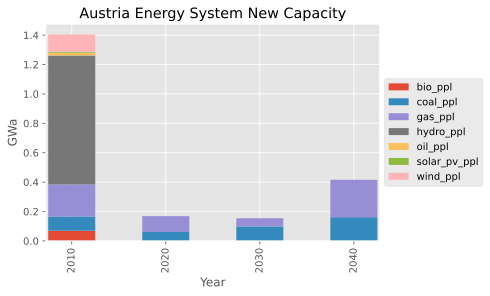

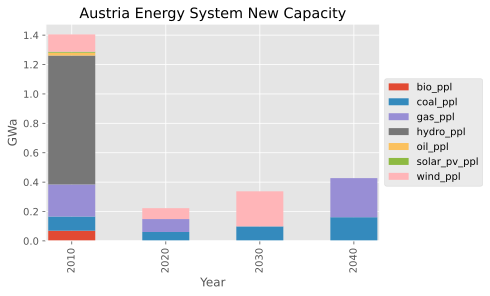

In [6]:
# Prepare a Reporter based on the solved scenario
wind_rep = Reporter.from_scenario(wind_scen)
prepare_plots(wind_rep)

# Run the same reporting code on both the base and modified scenarios
for r in base_rep, wind_rep:
    r.set_filters(t=plants)
    r.get("plot new capacity")

# Demand-Side Learning

This model does not use `cfl`s in the basline because they are too expensive. What happens if their cost reduces with time?

In [7]:
# Cost as a fraction of the baseline cost, due to learning
learning = np.array([1.0, 0.6, 0.3, 0.1])

with solve_modified(base_scen, new_name="cheap_cfls") as cfl_scen:
    # Load the investment cost data (cloned from `base_scen`) for cfl
    data = wind_scen.par("inv_cost", filters=dict(technology="cfl"))
    
    # Reduce the values according to the learning curve
    data["value"] = data["value"] * learning
    
    # Overwrite the values in `cfl_scen` at the same indices
    cfl_scen.add_par("inv_cost", data)

# Display the new costs
data

,node_loc,technology,year_vtg,value,unit
0,Austria,cfl,2010,900.0,USD/kW
1,Austria,cfl,2020,540.0,USD/kW
2,Austria,cfl,2030,270.0,USD/kW
3,Austria,cfl,2040,90.0,USD/kW


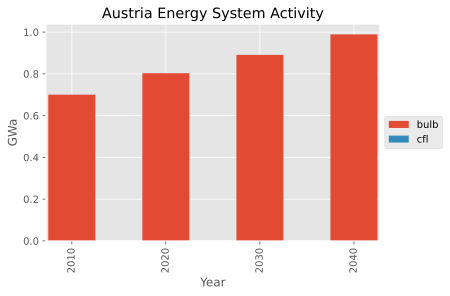

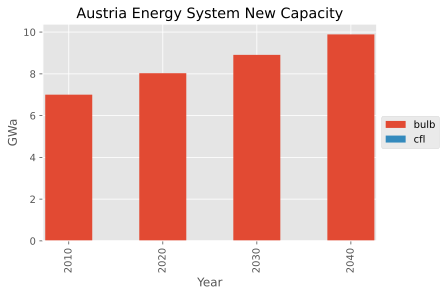

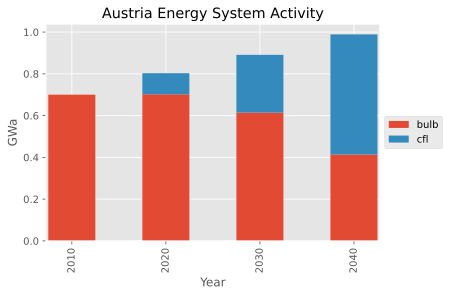

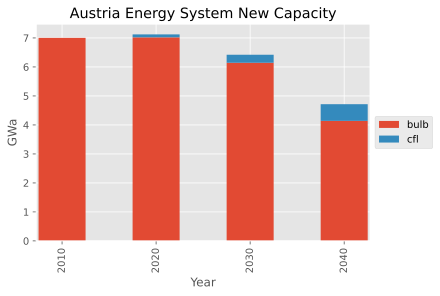

In [8]:
# Prepare a Reporter based on the solved scenario
cfl_rep = Reporter.from_scenario(cfl_scen)
prepare_plots(cfl_rep)

# Run the same reporting code on both the base and modified scenarios
for r in base_rep, cfl_rep:
    r.set_filters(t=lights)
    r.get("plot activity")
    r.get("plot new capacity")

# Exercise: Economic Assumptions

What is the effect of assuming a different interest rate? What if it is higher than the baseline? Lower? How does this affect prices?

In [9]:
# Show the baseline interest rate
base_scen.par('interestrate')

,year,value,unit
0,2010,0.05,-
1,2020,0.05,-
2,2030,0.05,-
3,2040,0.05,-


In [10]:
with solve_modified(base_scen, new_name="high_interest_rate") as econ_scen:
    econ_scen.add_par("interestrate", horizon, value=0.1, unit='%')

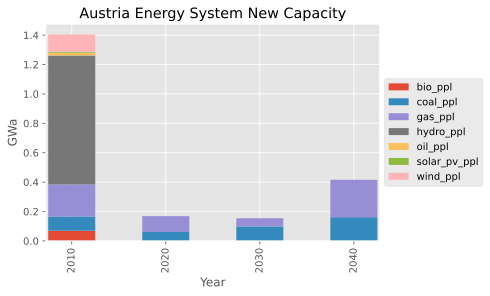

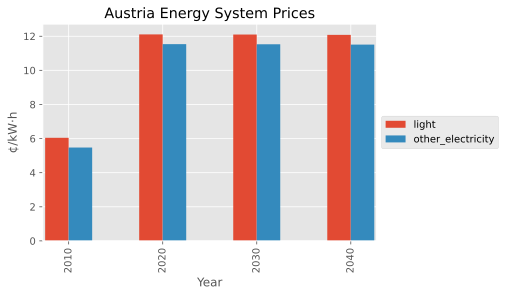

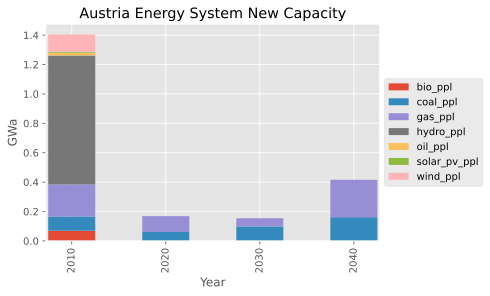

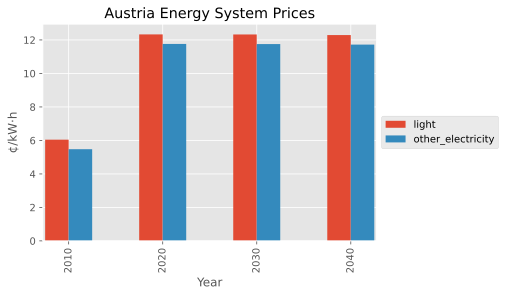

In [11]:
# Prepare a Reporter based on the solved scenario
econ_rep = Reporter.from_scenario(econ_scen)
prepare_plots(econ_rep)

# Run the same reporting on both the base and modified scenarios
for r in base_rep, econ_rep:
    r.set_filters(t=plants, c=None)
    r.get("plot new capacity")
    r.set_filters(t=None, c=["light", "other_electricity"])
    r.get("plot prices")

# Exercise: Carbon Tax

What effect does a carbon tax have on the system? What if it is phased in over time? What is the effect on energy prices?

Hints:

- what emissions parameters are available from `scenario.par_list()`?
- find out which fields are required using `scenario.idx_names(par_name)`
- carbon taxes are normally provided in units of USD/tCO2
- a normal proposed carbon tax is ~30 USD/tCO2

In [12]:
# Print the names of all parameters that contain "emission"
[name for name in base_scen.par_list() if "emission" in name]

['emission_factor',
 'historical_emission',
 'emission_scaling',
 'bound_emission',
 'tax_emission',
 'land_emission']

In [13]:
# Print the index names for one of these
base_scen.idx_names("tax_emission")

['node', 'type_emission', 'type_tec', 'type_year']

In [14]:
taxes = pd.DataFrame({
    "node": country,
    "type_emission": "GHGs",
    "type_year": horizon,
    "type_tec": "all",
    "value": np.array([0.0, 20.0, 30., 40.]),
    "unit": 'USD/tCO2', 
})

with solve_modified(base_scen, new_name="carbon_tax") as ctax_scen:
    ctax_scen.add_par('tax_emission', taxes)

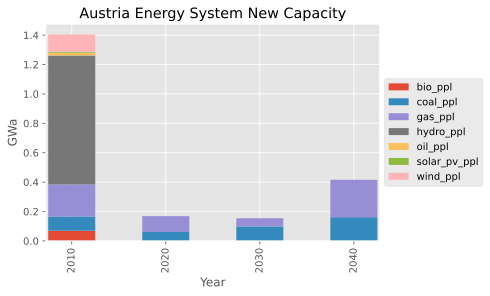

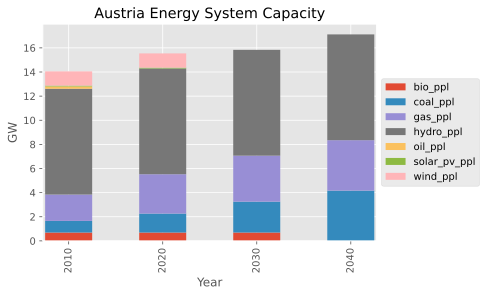

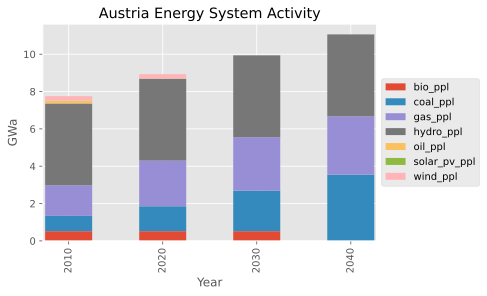

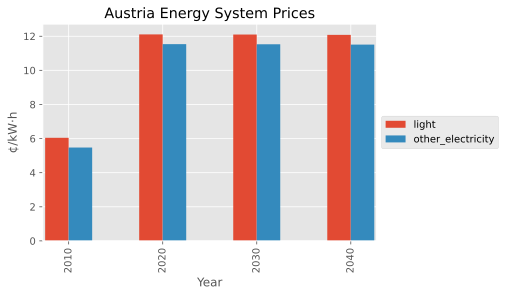

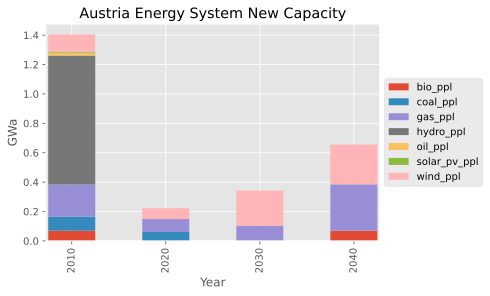

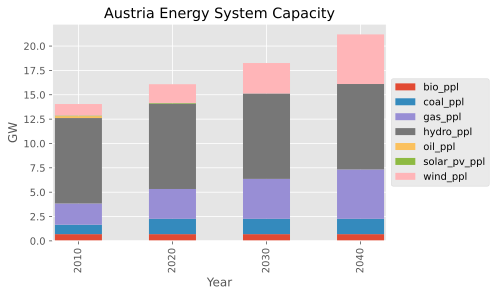

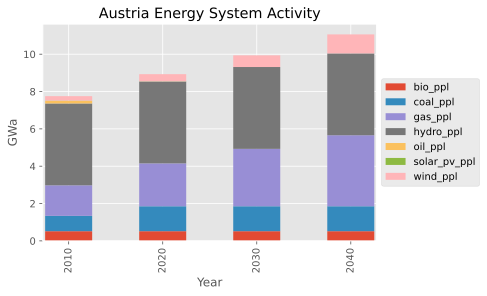

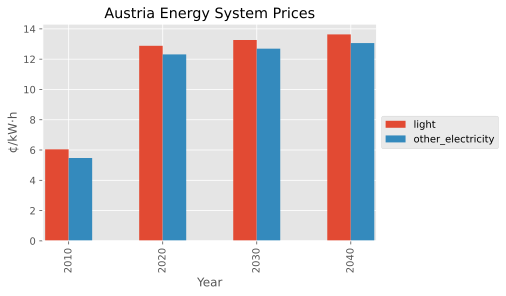

In [15]:
# Prepare a Reporter based on the solved scenario
ctax_rep = Reporter.from_scenario(ctax_scen)
prepare_plots(ctax_rep)

# Run the same reporting on both the base and modified scenarios
for r in base_rep, ctax_rep:
    r.set_filters(t=plants, c=None)
    r.get("plot new capacity")
    r.get("plot capacity")
    r.get("plot activity")
    r.set_filters(t=None, c=["light", "other_electricity"])
    r.get("plot prices")